# Minimize RMS
Given some example data, can we predict which combination of features (`I0`, `K1Q1`, `K1Q2`, `SIGT`, `SIGX`, `SIGY`) minimize beam spread (`RMSX` and `RMSY`)?

In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.optimize import minimize, LinearConstraint
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [2]:
RANDOM_STATE = 42

In [3]:
# read in data, configure dataframe
target_directory = 'data/test4'

x_dictlist, y_dictlist = [], []

for json_file in os.listdir(target_directory):
    if json_file[-4:] != 'json':
        continue

    with open(f'{target_directory}/{json_file}') as f:
        samples = json.load(f)['samples']
        dvars = [samples[i]['dvar'] for i in samples.keys()]
        objs = [samples[i]['obj'] for i in samples.keys()]
        
        x_dictlist += dvars
        y_dictlist += objs
        
x_df = pd.DataFrame(x_dictlist).apply(pd.to_numeric)
y_df = pd.DataFrame(y_dictlist).apply(pd.to_numeric)

In [6]:
# important for later
FEATURES = x_df.columns
assert(' ' not in ''.join(FEATURES))
assert('^' not in ''.join(FEATURES))

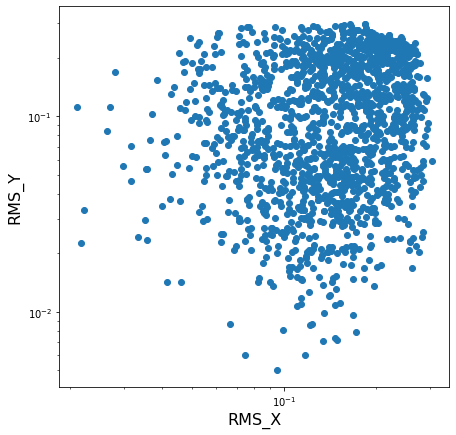

In [7]:
fig = plt.figure(figsize=(7,7))
plt.scatter(y_df['RMS_X'], y_df['RMS_Y'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('RMS_X', size=16)
plt.ylabel('RMS_Y', size=16)
plt.show()

## Eyeballing it
Let's start by finding the minimum Euclidean distance of the RMS components to the origin.

In [8]:
min_dist = np.sqrt(y_df['RMS_X']**2 + y_df['RMS_Y']**2).argsort()[:10]
x_df.loc[min_dist]

,CORX,CORY,I0,K1Q1,K1Q2,SIGT,SIGX,SIGY
753,0.981039,0.014609,1.654746,11.756401,22.466725,0.052119,0.034866,0.023132
563,0.999777,-0.483853,3.305557,13.496769,33.791106,0.027970,0.016988,0.019369
561,0.861349,-0.838454,8.052974,11.332667,14.201922,0.079742,0.023031,0.027775
777,0.940748,0.026611,4.716066,11.311309,23.770599,0.027548,0.040424,0.038098
1121,0.943172,-0.901158,1.576094,11.064520,18.464807,0.064067,0.048066,0.021578
588,0.821046,-0.200234,1.031947,17.923475,20.723958,0.019516,0.011994,0.022832
260,0.818617,0.261918,2.013593,10.701478,20.786199,0.008418,0.026714,0.017630
1110,0.934231,-0.866756,4.504305,12.908805,36.248990,0.004174,0.026884,0.034905
521,0.708960,-0.696280,5.731923,11.612797,11.605201,0.028531,0.030658,0.023114
957,0.942769,0.065856,9.575343,13.551697,18.245942,0.094697,0.025033,0.017430


In [9]:
y_df.loc[min_dist][['RMS_X', 'RMS_Y']]

,RMS_X,RMS_Y
753,0.021724,0.022451
563,0.022224,0.033088
561,0.033404,0.023996
777,0.035659,0.023163
1121,0.041386,0.014207
588,0.035279,0.029465
260,0.046051,0.014137
1110,0.039990,0.034833
521,0.042417,0.037607
957,0.031763,0.046953


We build a polynomial regression on the input variables, regressing on the RMS variables as features. We can then find the input variables that minimize $\sqrt{\mathtt{RMS_X}^2 + \mathtt{RMS_Y}^2}$.

### Fitting the regression
I take this to third order and include cross-terms.

In [10]:
# polynomialize data
poly = PolynomialFeatures(3, include_bias=False)
x_poly_values = poly.fit_transform(x_df)
x_poly_df = pd.DataFrame(x_poly_values, columns=poly.get_feature_names_out())

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    x_poly_df, y_df[['RMS_X', 'RMS_Y']], test_size=0.15, random_state=RANDOM_STATE
)

In [12]:
reg = LinearRegression().fit(x_train, y_train)
print('train set R^2: ', reg.score(x_train, y_train))
print('test set R^2: ', reg.score(x_test, y_test))

train set R^2:  0.9786068688543342
test set R^2:  0.9738916864243843


### The inverse problem

For features $\mathbf{x}$, and predicted response $\hat{\mathbf{y}} = \mathbf{f}(\mathbf{x})$ (for $\mathbf{f}$ our regression), I choose to numerically minimize $\| \hat{\mathbf{y}} \|$.

In [13]:
coefficients = reg.coef_ # 2 x 83
intercepts = reg.intercept_ # 2 x 2. Note that first dimensions corresponds to response dimensions

In [14]:
# set up kernel function
polynomial_features = poly.get_feature_names_out()
rms_x_coefficients, rms_y_coefficients = coefficients[0], coefficients[1]
rms_x_intercept, rms_y_intercept = intercepts[0], intercepts[1]

def _polynomial_feature_name_to_value(feature_vector, polynomial_feature_name):
    """
    Converts a polynomial_feature_name to a numerical expression given a feature_vector.
    
    Parameters
    ==========
    feature_vector: dict
        of the format {component: value, ...} where component is a string
    polynomial_feature_name: string
        e.g., 'K1Q2^2 SIGT'
        
    Returns
    =======
    value: float
        value of the polynomial feature
    """
    value = 1.
    
    for term in polynomial_feature_name.split(' '):
        if '^' in term:
            feature = term.split('^')[0]
            exponent = int(term.split('^')[1])
        else:
            feature = term
            exponent = 1
        value *= feature_vector[feature]**exponent
        
    return value
    
def predicted_euclidean_distance(x):
    feature_vector = {colname: x[i] for i, colname in enumerate(FEATURES)}
    
    polynomial_feature_vector = np.array(
        [
            _polynomial_feature_name_to_value(feature_vector, polynomial_feature_name)
            for polynomial_feature_name in polynomial_features
        ]
    )
    
    rms_x_hat = np.dot(rms_x_coefficients, polynomial_feature_vector) + rms_x_intercept
    rms_y_hat = np.dot(rms_y_coefficients, polynomial_feature_vector) + rms_y_intercept
    
    return np.sqrt(rms_x_hat**2 + rms_y_hat**2)

In [15]:
# sanity checking our gross helper function
fv = {'a': 1., 'b': 0., 'c': 4.}
pfn = 'c^2 a'
assert (_polynomial_feature_name_to_value(fv, pfn) == 16.)

In [32]:
# numerical optimization
first_guess = x_df.loc[min_dist[0]].values
res = minimize(
    predicted_euclidean_distance, first_guess, method='COBYLA',
    constraints=LinearConstraint(
        np.identity(x_df.shape[1]),
        lb=[-1., -1., 1., 5., 5., 0.001, 0.01, 0.01],
        ub=[1., 1., 10., 40., 40., 0.1, 0.05, 0.05],
        keep_feasible=False
    )
)

In [35]:
print({colname: res.x[i] for i, colname in enumerate(FEATURES)})

{'CORX': 1.0, 'CORY': -0.8846685956778625, 'I0': 2.4878326920926166, 'K1Q1': 12.32589695022987, 'K1Q2': 23.477868010169026, 'SIGT': 0.06659751217126848, 'SIGX': 0.01, 'SIGY': 0.0137145329479253}


In [43]:
x = {
    'CORX': 1.0,
    'CORY': -0.8846685956778625,
    'I0': 2.4878326920926166,
    'K1Q1': 12.32589695022987,
    'K1Q2': 23.477868010169026,
    'SIGT': 0.06659751217126848,
    'SIGX': 0.01,
    'SIGY': 0.0137145329479253
}
x = np.array([val for val in x.values()])
print(x)

[ 1.00000000e+00 -8.84668596e-01  2.48783269e+00  1.23258970e+01
  2.34778680e+01  6.65975122e-02  1.00000000e-02  1.37145329e-02]


In [44]:
predicted_euclidean_distance(x)

0.02789482739081775